## Correlations shown in paper and SISSO functions handlers

In [1]:
# import numpy as np
import os
import matplotlib
matplotlib.use('Agg') 
import sys
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

import multiprocessing
import time
import pickle


%matplotlib inline


cwd = os.getcwd()
sys.path.append(cwd+'/strength_model/')
from strength import model_Curtin, model_Control #model_Curtin is only for elas cons only, but takes a dictionary as an input

In [2]:
plt.rcParams.update({'font.size': 20})
plt.rc('mathtext', fontset="cm")
plt.rc('font',**{'family':'serif','serif':['Times']})
plt.rc('text', usetex=True)

# SISSO object for the use in correlations:
###### ult_eq: sisso equation retrieved from the output of FORTRAN SISSO
###### get_feature: returns a specific feature for a specific alloy
###### get_variance: returns the variance for an atomic property
###### print_formula_latex: retrieves tha final equation in a robust (no frac) latex style

In [3]:
import pandas as pd
import numpy as np
from itertools import combinations

### SISSO 3D ####
## the nature of the descriptor makes it difficult to work without a database of unary features
## The idea is for the descriptor to take the compositions of the predefined [Mn,Nb,Ta,V,W] vector
## The object only needs to be initialized once and then can be called

class SISSO:
    def __init__(self, csv_una,string_of,d,org_ele=['Mo','Nb','Ta','V','W']):
        self.df_una=pd.read_csv(csv_una)
        self.df_una.columns =[column.replace(" ", "_") for column in self.df_una.columns]
        self.df_una.columns =[column.replace("'", "_") for column in self.df_una.columns]
        self.df_una.columns =[column.replace("(", "_") for column in self.df_una.columns]
        self.df_una.columns =[column.replace(")", "_") for column in self.df_una.columns]
        self.df_una.columns =[column.replace("/", "_") for column in self.df_una.columns]
        self.df_una.columns=self.df_una.columns.str.lower()
        self.df_una=self.df_una.set_index('symbol',drop=True)
        self.org_ele=org_ele   #they have to be in alphabetical order 
        self.v_wo_df=[]
        
        features=self.df_una.columns
        raw=[]
        pattern = str(d)+"D descriptor"
        #print(features)
        with open(string_of) as file:
            all_lines = file.readlines()
            for current_line_no, current_line in enumerate(all_lines):
                if pattern in current_line:
                    for k in range(d+2):
                        raw.append(all_lines[current_line_no+3+k].split(':')[1])
                    break
        #print(raw)
        v_lines=[0]*d
        used_feat=[]
        for i in range(d):
            v_lines[i]=raw[i]
            v_lines[i]=v_lines[i][1:-2]
            self.v_wo_df.append(v_lines[i][:])
            v_lines[i]=v_lines[i].replace('^','**')
            v_lines[i]=v_lines[i].replace('exp','np.exp')
            v_lines[i]=v_lines[i].replace('sqrt','np.sqrt')
            v_lines[i]=v_lines[i].replace('log','np.log')
            
            for f in features:
                #print(f)

                if f in raw[i]:
                    if f not in used_feat:
                        used_feat.append(f)


                    v_lines[i]=v_lines[i].replace(f+'_avg','df[\''+f+'_avg'+'\'].values[0]')
                    v_lines[i]=v_lines[i].replace(f+'_red','df[\''+f+'_red'+'\'].values[0]')
                    v_lines[i]=v_lines[i].replace(f+'_diff','df[\''+f+'_diff'+'\'].values[0]')
        self._used_feat=used_feat
        self.a0=float(raw[-1])
        self.a=[float(i) for i in raw[-2].split()]
        #print(self.a0)
        #print(self.a)
        #print(v_lines)
        #print(used_feat)
        self.v_lines=v_lines
        self.features=features

            
    def _red_and_diff(self,ele, stoich, feature):
        df_una=self.df_una
        num_els=len(ele)
        denom = (num_els - 1) * np.sum(stoich)

        values=np.array([df_una.loc[ei,feature] for ei in ele])
        pairs = list(combinations(ele, 2))
        pair_red_lst = []
        pair_diff_lst = []
        for i in range(len(pairs)):
            first_elem = ele.index(pairs[i][0])
            second_elem = ele.index(pairs[i][1])
            pair_coeff = stoich[first_elem] + stoich[second_elem]
            pair_prod = values[first_elem] * values[second_elem]
            pair_sum = values[first_elem] + values[second_elem]

            pair_sub = np.abs(values[first_elem] - values[second_elem])

            pair_red = pair_coeff * pair_prod / pair_sum
            pair_diff = pair_coeff * pair_sub

            pair_red_lst.append(pair_red)
            pair_diff_lst.append(pair_diff)
        return np.sum(pair_red_lst) / denom , np.sum(pair_diff_lst) / denom

    def _only_avg(self,ele,stoich, feature):
        df_una=self.df_una
        
        values=np.array([df_una.loc[ei,feature] for ei in ele])
        average = np.average(values, weights=stoich)
        return average
    def _ult_eq(self,x):
        
        df=pd.DataFrame(index=[0])
        sisso_feat=self.features
        ele=[self.org_ele[i] for i in np.where(x>0)[0]]
        x=x[np.where(x>0)[0]]
        #print(x)
        for ss in sisso_feat:
            df[ss+'_avg']=self._only_avg(ele,x,ss)
            df[ss+'_red'],df[ss+'_diff']=self._red_and_diff(ele,x,ss)
        suma=self.a0
        
        for i,c in enumerate(self.a):
            suma=suma+self.a[i]*eval(self.v_lines[i])
        return suma
        
    def ult_eq(self,x):
    #### Only the SISSO called features are being calculated to lower the computation cost
    ####
        x=np.array(x)
        if len(x.shape)>1:
            return np.apply_along_axis(self._ult_eq, 1, x)
        else:
            return self._ult_eq(x)
        
        
    def print_formula_latex(self,ff,fl):
        #print(self.a0)
        d=len(self.v_lines)
        fchange=[0]*d
        for i,c in enumerate(self.a):
            fchange[i]=self.v_wo_df[i][:]
            for f,l in zip(ff,fl):
                fchange[i]=fchange[i].replace(f,l)
            fchange[i]=fchange[i].replace('log','\ln')
            fchange[i]=fchange[i].replace('*',' ')
            
        ws="{:.2E}".format(self.a0).replace('E','\\times 10 ^')
        dummy=ws.split('^')[1]
        intdummy=int(dummy)
        ws=ws.replace(dummy,'{'+str(intdummy)+'}')
        
        final_str='$\\begin{array}{c}\n'+ws[:]
        if intdummy==0:
            ws=ws.split('\\times')[0]
        for i in range(len(fchange)):
            
            
            
            ws="{:.2E}".format(self.a[i]).replace('E','\\times 10 ^')
            dummy=ws.split('^')[1]
            intdummy=int(dummy)
            ws=ws.replace(dummy,'{'+str(intdummy)+'}')
            if intdummy==0:
                ws=ws.split('\\times')[0]
            if self.a[i]<0:
                final_str=final_str+ws+fchange[i]+'\\\\\n'
            else:
                final_str=final_str+"+"+ws+fchange[i]+'\\\\\n'
        final_str=final_str+'\end{array}$'
        print(final_str)
        
    def _get_feature(self,x):
        ele=[self.org_ele[i] for i in np.where(x>0)[0]]
        x=x[np.where(x>0)[0]]
        #print(x)
        feature=self.feature_tmp
        if '_avg' in feature:
            feat=feature[:-4]
            return self._only_avg(ele,x,feat)
        if '_red' in feature:
            feat=feature[:-4]
            y1,y2=self._red_and_diff(ele,x,feat)
            return y1
        if '_diff' in feature:
            feat=feature[:-5]
            y1,y2=self._red_and_diff(ele,x,feat)
            return y2
    def get_feature(self,x,feature):
        self.feature_tmp=feature
        x=np.array(x)
        if len(x.shape)>1:
            return np.apply_along_axis(self._get_feature, 1, x)
        else:
            return self._get_feature(x)
        
    def _var_and_std(self, stoich):
        feature=self.feature_tmp
        ele=[self.org_ele[i] for i in np.where(stoich>0)[0]]
        x=stoich[np.where(stoich>0)[0]]
        
        
        df_una=self.df_una

        values=np.array([df_una.loc[ei,feature] for ei in ele])
        
        
        average = np.average(values, weights=x)
        # Fast and numerically precise:
        variance = np.average((values-average)**2, weights=x)
        return variance,np.sqrt(variance)
    
    def get_variance(self,x,feature):
        self.feature_tmp=feature
        x=np.array(x)
        if len(x.shape)>1:
            return np.apply_along_axis(self._get_variance, 1, x)
        else:
            return self._get_variance(x)
    
    def _get_variance(self,x):
        return self._var_and_std(x)[0]

In [4]:
!ls MyDrive/COLABSpaper/ownavgred200

ls: cannot access 'MyDrive/COLABSpaper/ownavgred200': No such file or directory


In [5]:
data_f='../data/'
res_f='../results/'

In [6]:
una=data_f+'UNARIES_NINE.csv'
ELE=['Mo','Nb','Ta','V','W']

In [7]:
sK = SISSO(una,data_f+'fromHPRC/K.avgvar00/dirUNIQUE/SISSO.out',3,org_ele=ELE)
sG= SISSO(una,data_f+'fromHPRC/G.avgvar00/dirUNIQUE/SISSO.out',3,org_ele=ELE)
sE= SISSO(una,data_f+'fromHPRC/E.avgvar00/dirUNIQUE/SISSO.out',3,org_ele=ELE)
sC11= SISSO(una,data_f+'fromHPRC/C_11.avgvar00/dirUNIQUE/SISSO.out',3,org_ele=ELE)
sC12= SISSO(una,data_f+'fromHPRC/C_12.avgvar00/dirUNIQUE/SISSO.out',3,org_ele=ELE)
sC44= SISSO(una,data_f+'fromHPRC/C_44.avgvar00/dirUNIQUE/SISSO.out',3,org_ele=ELE)
sv= SISSO(una,data_f+'fromHPRC/v.avgvar00/dirUNIQUE/SISSO.out',3,org_ele=ELE)
sGK= SISSO(una,data_f+'fromHPRC/GK.avgvar00/dirUNIQUE/SISSO.out',3,org_ele=ELE)
scauchy = SISSO(una,data_f+'fromHPRC/cauchy.avgvar00/dirUNIQUE/SISSO.out',3,org_ele=ELE)

##### atomic features in all models

In [8]:
sK.features

Index(['atomic_number', 'atomic_radius', 'en_pauling', 'density',
       'electron_affinity', 'en_allen', 'heat_of_formation',
       'lattice_constant', 'melting_point', 'period', 'valence'],
      dtype='object')

#### alloy-specific features and their latex analogous

In [11]:
features_full=[]
for i in sK.features:
    for j in ['_avg','_red','_diff']:
        features_full.append(i+j)

In [12]:
features_latex=[
 'Z_{avg}',
 'Z_{red}',
 'Z_{diff}',
 'r_{a,avg}',
 'r_{a,var}',
 'r_{a,diff}',
 '\\chi_{Pauling,avg}',
 '\\chi_{Pauling,red}',
 '\\chi_{Pauling,diff}',
 '\\rho_{avg}',
 '\\rho_{red}',
 '\\rho_{diff}',
 'E_{ea,avg}',
 'E_{ea,red}',
 'E_{ea,diff}',
 '\chi_{Allen,avg}',
 '\chi_{Allen,red}',
 '\chi_{Allen,diff}',
 '\Delta H_{f,avg}',
 '\Delta H_{f,red}',
 '\Delta H_{f,diff}',
 'a_{avg}',
 'a_{red}',
 'a_{diff}',
 'T_{m,avg}',
 'T_{m,red}',
 'T_{m,diff}',
 'P_{avg}',
 'P_{red}',
 'P_{diff}',
 'VEC_{avg}',
 'VEC_{red}',
 'VEC_{diff}']


###### latex equations

In [14]:
print('C11')
sC11.print_formula_latex(features_full,features_latex)
print('C12')
sC12.print_formula_latex(features_full,features_latex)
print('C44')
sC44.print_formula_latex(features_full,features_latex)
print('K')
sK.print_formula_latex(features_full,features_latex)
print('G')
sG.print_formula_latex(features_full,features_latex)
print('E')
sE.print_formula_latex(features_full,features_latex)
print('v')
sv.print_formula_latex(features_full,features_latex)
print('GK')
sGK.print_formula_latex(features_full,features_latex)
print('cauchy')
scauchy.print_formula_latex(features_full,features_latex)

C11
$\begin{array}{c}
1.16\times 10 ^{1}+1.14((VEC_{avg})^3 sqrt(P_{avg}))\\
+4.77\times 10 ^{1}((VEC_{diff})^6)^6\\
-2.94\times 10 ^{-2}((a_{avg})^6 (VEC_{red}+VEC_{diff}))\\
\end{array}$
C12
$\begin{array}{c}
1.31\times 10 ^{2}+1.26((\rho_{avg} \chi_{Pauling,red}) (\chi_{Pauling,avg}+\chi_{Pauling,diff}))\\
-1.44\times 10 ^{2}((VEC_{diff})^6 (VEC_{red} E_{ea,red}))\\
+3.72\times 10 ^{2}((VEC_{diff})^3 (VEC_{diff} E_{ea,red}))\\
\end{array}$
C44
$\begin{array}{c}
-3.19\times 10 ^{2}+1.01\times 10 ^{2}(sqrt(P_{avg}) (VEC_{avg}/a_{avg}))\\
-1.87\times 10 ^{1}((VEC_{diff})^6)^6\\
-5.57\times 10 ^{-2}((E_{ea,avg}-E_{ea,diff})/(\chi_{Pauling,diff} a_{diff}))\\
\end{array}$
K
$\begin{array}{c}
-1.56\times 10 ^{2}+3.92(sqrt(T_{m,avg}) (VEC_{avg}/a_{avg}))\\
+1.95\times 10 ^{2}((T_{m,diff}/a_{diff})/(\rho_{avg})^6)\\
+6.92\times 10 ^{3}((VEC_{avg}+VEC_{diff})/(a_{avg} \Delta H_{f,avg}))\\
\end{array}$
G
$\begin{array}{c}
1.50\times 10 ^{2}-2.39\times 10 ^{4}((a_{avg}/P_{avg})/exp(VEC_{avg}))\

#### sampling used in SISSO_function

In [16]:
elements = ELE
str_ele=''
for i in elements:
    str_ele=str_ele+i
print(str_ele)
d = len(elements)
n = int(1.0e5)
rand_seed = 98

np.random.seed(rand_seed)
X = np.random.rand(n,d)

X = -np.log(X)
print(np.size(X,0))
for i in range(np.size(X,0)):
    X[i,:] = X[i,:]/sum(X[i,:])
print(np.sum(X,axis=1))

MoNbTaVW
100000
[1. 1. 1. ... 1. 1. 1.]


In [17]:
features_full

['atomic_number_avg',
 'atomic_number_red',
 'atomic_number_diff',
 'atomic_radius_avg',
 'atomic_radius_red',
 'atomic_radius_diff',
 'en_pauling_avg',
 'en_pauling_red',
 'en_pauling_diff',
 'density_avg',
 'density_red',
 'density_diff',
 'electron_affinity_avg',
 'electron_affinity_red',
 'electron_affinity_diff',
 'en_allen_avg',
 'en_allen_red',
 'en_allen_diff',
 'heat_of_formation_avg',
 'heat_of_formation_red',
 'heat_of_formation_diff',
 'lattice_constant_avg',
 'lattice_constant_red',
 'lattice_constant_diff',
 'melting_point_avg',
 'melting_point_red',
 'melting_point_diff',
 'period_avg',
 'period_red',
 'period_diff',
 'valence_avg',
 'valence_red',
 'valence_diff']

### results read from the data/results folder (also saved in results from SISSO_function.ipynb)

In [20]:
df=pd.read_csv(data_f+'results/results_SISSO_obj'+str(rand_seed)+str(n)+'.csv')

In [21]:
df

,Unnamed: 0,Mo,Nb,Ta,V,W,K,G,E,C_11,C_12,C_44,v,GK,cauchy
0,0,0.103056,0.187540,0.396833,0.081924,0.230647,222.909599,66.497325,198.985877,310.794253,175.049213,75.330698,0.349457,0.330808,109.131875
1,1,0.280739,0.124630,0.122582,0.143194,0.328855,247.122241,91.400105,250.570967,375.406967,181.164155,94.334290,0.328351,0.385298,90.958751
2,2,0.298227,0.264769,0.020448,0.364459,0.052098,208.300894,57.240373,159.867360,298.566605,162.275669,55.430933,0.372911,0.284616,107.847816
3,3,0.005126,0.415579,0.170636,0.019339,0.389320,228.706649,70.465051,202.181051,322.253389,178.574845,78.524074,0.348332,0.324548,112.833329
4,4,0.069315,0.223607,0.004114,0.067489,0.635475,266.024399,109.306215,282.056206,408.556823,193.468228,110.389480,0.316539,0.403651,87.537470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,0.181640,0.351609,0.087898,0.147331,0.231523,222.350162,68.270906,191.062012,320.216480,171.855994,71.345677,0.355392,0.316536,107.331436
99996,99996,0.164948,0.356452,0.134817,0.184905,0.158878,212.113461,58.680345,169.056924,298.422180,167.780319,62.269796,0.366472,0.291737,112.148080
99997,99997,0.427297,0.001717,0.149793,0.136534,0.284659,256.549720,100.402749,277.408436,402.165663,183.140416,103.305328,0.316796,0.419483,81.689398
99998,99998,0.503631,0.032741,0.020348,0.134860,0.308419,264.017341,110.468402,292.505218,425.022150,184.386010,108.496951,0.311379,0.433932,75.253063


In [23]:
def _model_sys_strength(x):
    return model_Control(ELE,x,bar_C=[sC11.ult_eq(x),sC12.ult_eq(x),sC44.ult_eq(x)])
def model_sys_strength(x):
    if len(x.shape)>1:
        return np.apply_along_axis(_model_sys_strength, 1, x)
    else:
        return _model_sys_strength(x)

#### calculate strength using SISSO elastic constants

In [24]:
tic=time.time()
pool=multiprocessing.Pool()
strength_v=pool.map(model_sys_strength,X)

In [25]:
strength_v=np.vstack(strength_v)
s_v=strength_v[:,0]

### matrix of alloy-specific features

In [26]:
w=np.zeros((X.shape[0],len(features_full)),dtype=float)
for c,i in enumerate(features_full):
    w[:,c]=sC11.get_feature(X,i)

### matrix of feature variances

In [27]:
feat_var=sK.features
feat_var=list(feat_var)
var=np.zeros((X.shape[0],len(feat_var)),dtype=float)
for c,i in enumerate(feat_var):
    var[:,c]=sC11.get_variance(X,i)
    #print(c,i)


### points for Quaternary MoNbTaW and MoNbTaVW

In [28]:
pQui=np.array([0.2,0.2,0.2,0.2,0.2])
pQua=np.array([0.25,0.25,0.25,0,0.25])

### Yield strength correlations with variances

In [23]:
st_ct=3.067

In [24]:
dpi=500

#### E and yield strength correlation with variances,extract from figure 8

NameError: name 'st_ct' is not defined

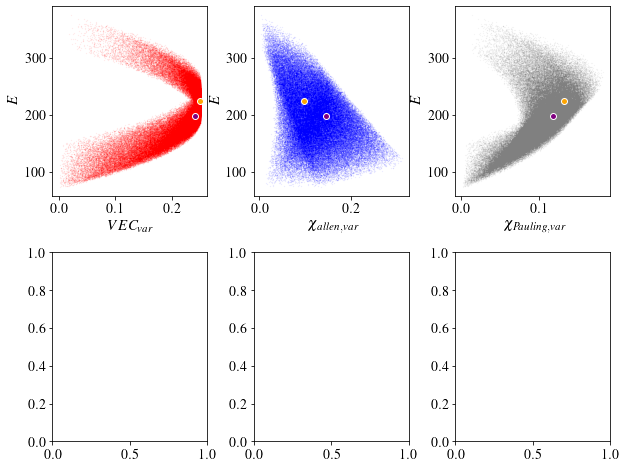

In [29]:
###yield
plt.rcParams.update({'font.size': 14})

plt.rc('mathtext', fontset="cm")
colorm=['r','b','gray','teal','#746352','#456272','teal','#746352','#456272']

fig, ax = plt.subplots(2,3,figsize=(10,8))
plt.subplots_adjust(hspace = 0.3)
plt.subplots_adjust(wspace = 0.3)
feat_var=list(sK.features)
cases=['E','strength']
cases_l=[r'$E$',r'$\sigma_{y0}$']
model_cases=[sE,None]
f_cases=['valence','en_allen','en_pauling']
f_cases_l=[r'$VEC_{var}$',r'$\chi_{allen,var}$',r'$\chi_{Pauling,var}$']
c=0
model_list=[]
for i,ii in enumerate(cases):
        
    for j,jj in enumerate(f_cases):
        if i<1:
            ax[i,j].scatter(var[:,feat_var.index(jj)],df[[ii]].values,s=0.1,color=colorm[c],alpha=0.1)
            ax[i,j].set_xlabel(f_cases_l[j],fontsize=15)
            ax[i,j].set_ylabel(cases_l[i],fontsize=15)
            ax[i,j].scatter(sK.get_variance(pQua,jj),model_cases[i].ult_eq(pQua),label=r'Quaternary',color='orange',edgecolors='white')
            ax[i,j].scatter(sK.get_variance(pQui,jj),model_cases[i].ult_eq(pQui),label=r'Quinary',color='purple',edgecolors='white')
            c=c+1
        else:
            ax[i,j].scatter(var[:,feat_var.index(jj)],s_v*st_ct,s=0.1,color=colorm[c],alpha=0.1)
            ax[i,j].set_xlabel(f_cases_l[j],fontsize=15)
            ax[i,j].set_ylabel(cases_l[i],fontsize=15)
            ax[i,j].scatter(sK.get_variance(pQua,jj),model_sys_strength(pQua)[0]*st_ct,label=r'Quaternary',color='orange',edgecolors='white')
            ax[i,j].scatter(sK.get_variance(pQui,jj),model_sys_strength(pQui)[0]*st_ct,label=r'Quinary',color='purple',edgecolors='white')
            c=c+1
#plt.savefig('vars'+'dpi'+str(dpi)+'.png',dpi=dpi,)                        

In [26]:
###calculate yield strength for all the sampling
df_sub=df
df_sub['strength']=s_v
df_sub['yield']=s_v*st_ct


## subsampling with predicted high strength

In [ ]:

df_random=df_sub.loc[[81009, 58683, 54998, 21948, 1315, 12714, 81300, 57747, 99912, 61084]]

In [ ]:
df_random[['Mo','Nb','Ta','V','W']].values

In [ ]:
df_random['E'].values,df_random['strength'].values

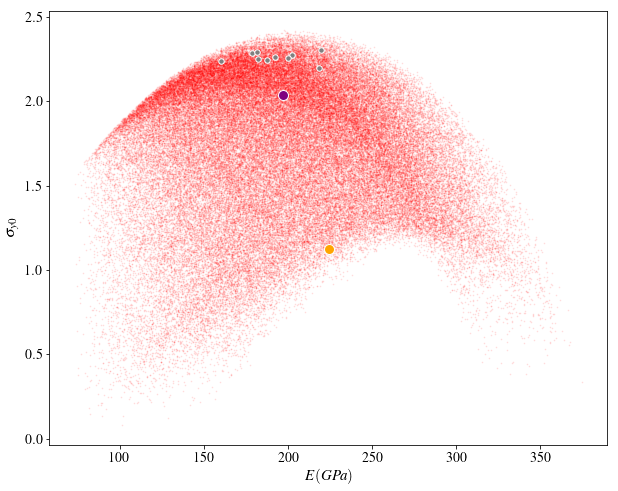

In [30]:
###3pres image
plt.rcParams.update({'font.size': 14})

plt.rc('mathtext', fontset="cm")
colorm=['r','b','gray','teal','#746352','#456272','teal','#746352','#456272']
c=0
fig, ax = plt.subplots(1,1,figsize=(10,8))
plt.subplots_adjust(hspace = 0.3)
plt.subplots_adjust(wspace = 0.35)

ax.scatter(df['E'].values,s_v*3.067,s=0.5,color=colorm[c],alpha=0.1)


ax.scatter(df_random['E'].values,df_random['yield'].values, s=30, color='gray',edgecolors='white')

ax.set_xlabel(r'$E(GPa)$',fontsize=15)
ax.set_ylabel(r'$\sigma_{y0}$',fontsize=15)

ax.scatter(sE.ult_eq(pQua),model_sys_strength(pQua)[0]*st_ct,label=r'Quaternary',color='orange',edgecolors='white',s=100)
ax.scatter(sE.ult_eq(pQui),model_sys_strength(pQui)[0]*st_ct,label=r'Quinary',color='purple',edgecolors='white',s=100)
plt.savefig('yield'+'dpi'+str(dpi)+'.png',dpi=dpi,)                        

In [31]:
df_random['density']=sE.get_feature(df_random[ELE].values,'density_avg')

In [32]:
df_random[ELE + ['density','C_11','E','K','strength','yield']].reset_index(drop=True)

,Mo,Nb,Ta,V,W,density,C_11,E,K,strength,yield
0,0.103117,0.086344,0.128700,0.312031,0.369808,12.980997,343.868469,219.757666,235.920243,0.752059,2.306566
1,0.233075,0.013075,0.322002,0.229115,0.202733,13.169338,334.725786,218.110471,230.483074,0.716678,2.198051
2,0.010748,0.007812,0.405863,0.268040,0.307537,14.509225,313.371424,202.116532,225.532184,0.741716,2.274842
3,0.176837,0.090773,0.108411,0.413097,0.210881,10.984713,317.171690,187.563752,220.560146,0.731273,2.242814
4,0.168377,0.020851,0.345996,0.347535,0.117242,12.047923,297.992623,178.353791,213.179160,0.744703,2.284005
5,0.031782,0.239756,0.058954,0.282206,0.387303,12.560555,328.261624,200.070122,229.033738,0.736148,2.257767
6,0.195702,0.088353,0.137590,0.408176,0.170179,10.827090,311.579480,182.397622,217.542151,0.733307,2.249053
7,0.086442,0.019394,0.145436,0.462793,0.285936,11.817955,318.276281,192.160987,223.399417,0.737254,2.261158
8,0.199772,0.006871,0.301005,0.448963,0.043389,10.694062,285.397180,160.258729,205.109815,0.730656,2.240923
9,0.046703,0.153191,0.061733,0.427393,0.310980,11.431545,312.310515,181.519115,220.393740,0.747062,2.291238


## high strength alloys

In [33]:
df_random[ELE + ['density','C_11','E','K','strength','yield']].sort_values('density').reset_index(drop=True).round(3)

,Mo,Nb,Ta,V,W,density,C_11,E,K,strength,yield
0,0.200,0.007,0.301,0.449,0.043,10.694,285.397,160.259,205.110,0.731,2.241
1,0.196,0.088,0.138,0.408,0.170,10.827,311.579,182.398,217.542,0.733,2.249
2,0.177,0.091,0.108,0.413,0.211,10.985,317.172,187.564,220.560,0.731,2.243
3,0.047,0.153,0.062,0.427,0.311,11.432,312.311,181.519,220.394,0.747,2.291
4,0.086,0.019,0.145,0.463,0.286,11.818,318.276,192.161,223.399,0.737,2.261
5,0.168,0.021,0.346,0.348,0.117,12.048,297.993,178.354,213.179,0.745,2.284
6,0.032,0.240,0.059,0.282,0.387,12.561,328.262,200.070,229.034,0.736,2.258
7,0.103,0.086,0.129,0.312,0.370,12.981,343.868,219.758,235.920,0.752,2.307
8,0.233,0.013,0.322,0.229,0.203,13.169,334.726,218.110,230.483,0.717,2.198
9,0.011,0.008,0.406,0.268,0.308,14.509,313.371,202.117,225.532,0.742,2.275


In [34]:
#features for the correlation plots
features_latex=[
 r'$Z_{avg}$',
 r'$Z_{red}$',
 r'$Z_{diff}$',
 r'$r_{a}^{avg}$',
 r'$r_{a}^{var}$',
 r'$r_{a}^{diff}$',
 r'$\chi_{Pauling}^{avg}$',
 r'$\chi_{Pauling}^{red}$',
 r'$\chi_{Pauling}^{diff}$',
 r'$\rho_{avg}$',
 r'$\rho_{red}$',
 r'$\rho_{diff}$',
 r'$E_{ea}^{avg}$',
 r'$E_{ea}^{red}$',
 r'$E_{ea}^{diff}$',
 r'$\chi_{Allen}^{avg}$',
 r'$\chi_{Allen}^{red}$',
 r'$\chi_{Allen}^{diff}$',
 r'$\Delta H_{f,avg}$',
 r'$\Delta H_{f,red}$',
 r'$\Delta H_{f,diff}$',
 r'$a_{avg}$',
 r'$a_{red}$',
 r'$a_{diff}$',
 r'$T_{m}^{avg}$',
 r'$T_{m}^{red}$',
 r'$T_{m}^{diff}$',
 r'$P_{avg}$',
 r'$P_{red}$',
 r'$P_{diff}$',
 r'$VEC_{avg}$',
 r'$VEC_{red}$',
 r'$VEC_{diff}$']

In [35]:
sC11.print_formula_latex(features_full,features_latex)

$\begin{array}{c}
1.16\times 10 ^{1}+1.14(($VEC_{avg}$)^3 sqrt($P_{avg}$))\\
+4.77\times 10 ^{1}(($VEC_{diff}$)^6)^6\\
-2.94\times 10 ^{-2}(($a_{avg}$)^6 ($VEC_{red}$+$VEC_{diff}$))\\
\end{array}$


## C_11

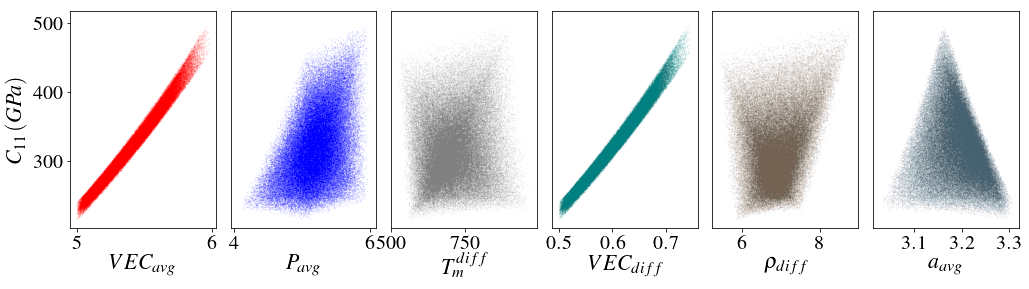

In [36]:
######
## C_11
plt.rcParams.update({'font.size': 20})

plt.rc('mathtext', fontset="cm")
colorm=['r','b','gray','teal','#746352','#456272']

fig, ax = plt.subplots(1,6,figsize=(17,4))
plt.subplots_adjust(hspace = 0.3)
plt.subplots_adjust(wspace = 0.1)
cases=['C_11']
cases_l=[r'$C_{11} \left ( GPa \right )$']
#model_cases=[sK]
f_cases=['valence_avg','period_avg','melting_point_diff','valence_diff','density_diff','lattice_constant_avg']
f_cases_l=[features_latex[features_full.index(i)] for i in f_cases]

c=0
model_list=[]
for i,ii in enumerate(cases):
    for j,jj in enumerate(f_cases):
        ax[j].scatter(w[:,features_full.index(jj)],df['C_11'].values,s=0.1,color=colorm[c],alpha=0.1)
        ax[j].set_xlabel(f_cases_l[j],fontsize=22)
        ax[0].set_ylabel(cases_l[i],fontsize=22)
        if j !=0:
            ax[j].axes.yaxis.set_ticks([])
        c=c+1
#plt.savefig('c11features.png',dpi=500,bbox_inches='tight')

## E

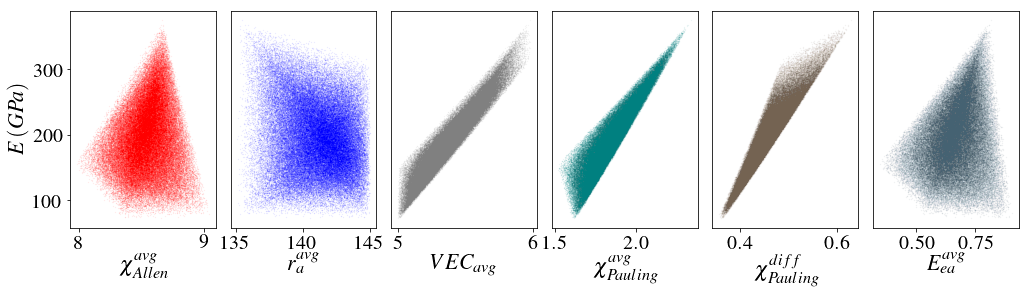

In [37]:
###strength
plt.rcParams.update({'font.size': 20})

plt.rc('mathtext', fontset="cm")
colorm=['r','b','gray','teal','#746352','#456272']

fig, ax = plt.subplots(1,6,figsize=(17,4))
plt.subplots_adjust(hspace = 0.3)
plt.subplots_adjust(wspace = 0.1)
cases=['E']
cases_l=[r'$E \left ( GPa \right )$']
#model_cases=[sK]
f_cases=['en_allen_avg',   'atomic_radius_avg',        'valence_avg','en_pauling_avg','en_pauling_diff','electron_affinity_avg']
f_cases_l=[features_latex[features_full.index(i)] for i in f_cases]
c=0
model_list=[sE]
for i,ii in enumerate(cases):
    for j,jj in enumerate(f_cases):
        ax[j].scatter(w[:,features_full.index(jj)],df[cases[0]].values,s=0.1,color=colorm[c],alpha=0.1)
        ax[j].set_xlabel(f_cases_l[j],fontsize=22)
        ax[0].set_ylabel(cases_l[i],fontsize=22)
        if j !=0:
            ax[j].axes.yaxis.set_ticks([])
        c=c+1
        
#plt.savefig('Efeatures.png',dpi=500,bbox_inches='tight')

# Same colors as in feature frequency analysis

In [38]:
## apply same colors as in the feature frequency case

strings="atomic_number_avg atomic_number_red atomic_number_diff atomic_radius_avg atomic_radius_red atomic_radius_diff en_pauling_avg en_pauling_red en_pauling_diff density_avg density_red density_diff electron_affinity_avg electron_affinity_red electron_affinity_diff en_allen_avg en_allen_red en_allen_diff heat_of_formation_avg heat_of_formation_red heat_of_formation_diff lattice_constant_avg lattice_constant_red lattice_constant_diff melting_point_avg melting_point_red melting_point_diff period_avg period_red period_diff valence_avg valence_red valence_diff"

strings=strings.split()

import matplotlib.colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

# Sort colors by hue, saturation, value and name.
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                for name, color in colors.items())
sorted_names = [name for hsv, name in by_hsv]
feat_col=[0]*len(strings)


int_n=int(len(sorted_names)/len(strings))


print(len(feat_col))
for ci,i in enumerate(range(0,int_n*len(strings),int_n)):
    #print(i)#len(sorted_names)
    #print(ci,i)
    feat_col[ci]=sorted_names[i]
    

33


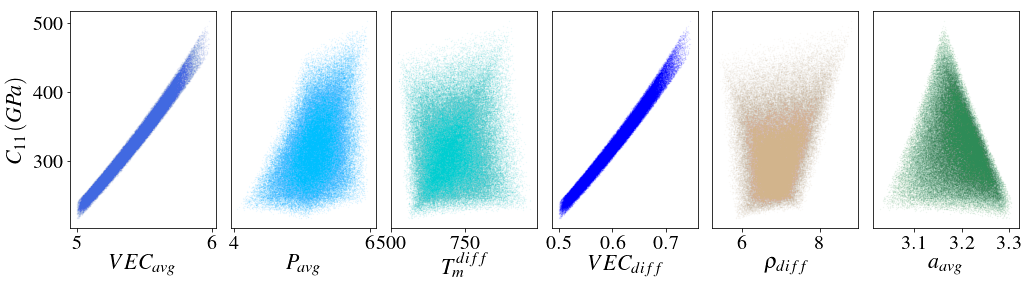

In [39]:
######
## C_11
plt.rcParams.update({'font.size': 20})

plt.rc('mathtext', fontset="cm")
colorm=['r','b','gray','teal','#746352','#456272']

fig, ax = plt.subplots(1,6,figsize=(17,4))
plt.subplots_adjust(hspace = 0.3)
plt.subplots_adjust(wspace = 0.1)
cases=['C_11']
cases_l=[r'$C_{11} \left ( GPa \right )$']
#model_cases=[sK]
f_cases=['valence_avg','period_avg','melting_point_diff','valence_diff','density_diff','lattice_constant_avg']
f_cases_l=[features_latex[features_full.index(i)] for i in f_cases]

c=0
model_list=[]
for i,ii in enumerate(cases):
    for j,jj in enumerate(f_cases):
        ax[j].scatter(w[:,features_full.index(jj)],df['C_11'].values,s=0.1,color=feat_col[strings.index(jj)],alpha=0.1)
        ax[j].set_xlabel(f_cases_l[j],fontsize=22)
        ax[0].set_ylabel(cases_l[i],fontsize=22)
        if j !=0:
            ax[j].axes.yaxis.set_ticks([])
        c=c+1
plt.savefig('c11featuresSAMECOLOR.png',dpi=500,bbox_inches='tight')

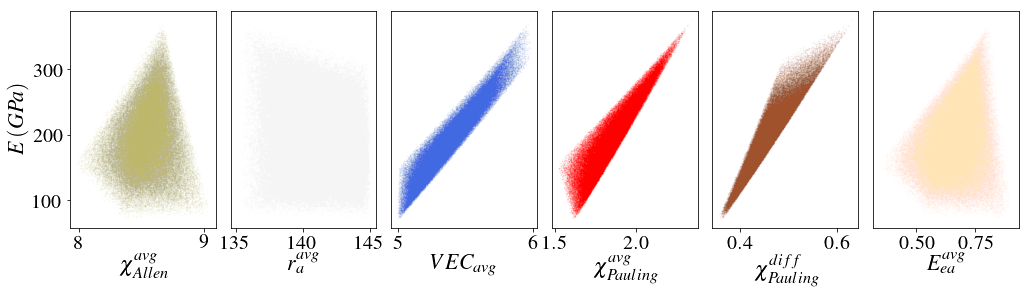

In [40]:
###strength
plt.rcParams.update({'font.size': 20})

plt.rc('mathtext', fontset="cm")
colorm=['r','b','gray','teal','#746352','#456272']

fig, ax = plt.subplots(1,6,figsize=(17,4))
plt.subplots_adjust(hspace = 0.3)
plt.subplots_adjust(wspace = 0.1)
cases=['E']
cases_l=[r'$E \left ( GPa \right )$']
#model_cases=[sK]
f_cases=['en_allen_avg',   'atomic_radius_avg',        'valence_avg','en_pauling_avg','en_pauling_diff','electron_affinity_avg']
f_cases_l=[features_latex[features_full.index(i)] for i in f_cases]
c=0
model_list=[sE]
for i,ii in enumerate(cases):
    for j,jj in enumerate(f_cases):
        ax[j].scatter(w[:,features_full.index(jj)],df[cases[0]].values,s=0.1,color=feat_col[strings.index(jj)],alpha=0.1)
        ax[j].set_xlabel(f_cases_l[j],fontsize=22)
        ax[0].set_ylabel(cases_l[i],fontsize=22)
        if j !=0:
            ax[j].axes.yaxis.set_ticks([])
        c=c+1
        
plt.savefig('EfeaturesSAMECOLOR.png',dpi=500,bbox_inches='tight')

## Quaternary and Quinary

In [41]:
df_p=pd.DataFrame(columns=ELE,data=np.array([pQua,pQui]))

In [42]:
df_p

,Mo,Nb,Ta,V,W
0,0.25,0.25,0.25,0.0,0.25
1,0.20,0.20,0.20,0.2,0.20


In [45]:
sE.get_feature(np.array([pQua,pQui]),'density_avg'),sC11.ult_eq(np.array([pQua,pQui])),sE.ult_eq(np.array([pQua,pQui])),sK.ult_eq(np.array([pQua,pQui])),np.array([model_sys_strength(pQua)[0],model_sys_strength(pQui)[0]])

(array([ 13.686 ,  12.1708]),
 array([ 344.24733609,  320.80674498]),
 array([ 224.07443646,  196.8598195 ]),
 array([ 235.88653267,  223.14725009]),
 array([ 0.36607183,  0.66396462]))

In [46]:
sE.get_feature(np.array([pQua,pQui]),'density_avg'),sC11.ult_eq(np.array([pQua,pQui])),sE.ult_eq(np.array([pQua,pQui])),sK.ult_eq(np.array([pQua,pQui])),np.array([model_sys_strength(pQua)[0],model_sys_strength(pQui)[0]])

(array([ 13.686 ,  12.1708]),
 array([ 344.24733609,  320.80674498]),
 array([ 224.07443646,  196.8598195 ]),
 array([ 235.88653267,  223.14725009]),
 array([ 0.36607183,  0.66396462]))

In [47]:
df_p['density']=sE.get_feature(np.array([pQua,pQui]),'density_avg')
df_p['C_11']=sC11.ult_eq(np.array([pQua,pQui]))
df_p['E']=sE.ult_eq(np.array([pQua,pQui]))
df_p['K']=sK.ult_eq(np.array([pQua,pQui]))
df_p['strength']=np.array([model_sys_strength(pQua)[0],model_sys_strength(pQui)[0]])
df_p['yield']=np.array([model_sys_strength(pQua)[0]*3.067,model_sys_strength(pQui)[0]*3.067])

In [48]:
df_p

,Mo,Nb,Ta,V,W,density,C_11,E,K,strength,yield
0,0.25,0.25,0.25,0.0,0.25,13.6860,344.247336,224.074436,235.886533,0.366072,1.122742
1,0.20,0.20,0.20,0.2,0.20,12.1708,320.806745,196.859819,223.147250,0.663965,2.036379


In [49]:
df_p[['density','C_11','E','K','strength']]

,density,C_11,E,K,strength
0,13.6860,344.247336,224.074436,235.886533,0.366072
1,12.1708,320.806745,196.859819,223.147250,0.663965
